In [51]:
# Step 1: Import Libraries
import pandas as pd
import xml.etree.ElementTree as ET
import os
import re
import xmltodict
from datetime import datetime

def xml_to_dict(element):
    """Recursively converts an XML element and its children to a dictionary."""
    if len(element) == 0:
        return element.text
    return {child.tag: xml_to_dict(child) for child in element}

def pretty(d, indent=0):
   for key, value in d.items():
      print('\t' * indent + str(key))
      if isinstance(value, dict):
         pretty(value, indent+1)
      else:
         print('\t' * (indent+1) + str(value))

In [52]:
# Step 2: Load and Parse XML Data using pandas.read_xml
def load_performance_data(file_path):
    # Parse the XML file
    tree = ET.parse(file_path)
    root = tree.getroot()
    print("Loading PP data for: ", os.path.basename(file_path))

    # Extract date from filename
    date_match = re.search(r'\d{8}', os.path.basename(file_path))
    race_date = ""
    if date_match:
        race_date = date_match.group(0)

    # Extract track from filename
    track_name = os.path.basename(file_path).split('_')[0][-3:]
    
    # Extract each Race element within EntryRaceCard and convert to a dictionary
    races = []
    for race in root.findall('.//Race'):
        race_dict = xmltodict.parse(ET.tostring(race))['Race']
        if race_dict['BreedType']['Value'] != 'TB':
            continue
        race_dict = extract_general_race_info(race_dict, race_date, track_name)

        for entry in race.findall('.//Starters'):
            entry_dict = extract_entry_info(entry)
            workout_dict = extract_workout_info(entry)
            races.append({**race_dict, **entry_dict, **workout_dict})
        
    # Convert the list of dictionaries into a DataFrame
    df = pd.DataFrame(races)

    return df

def extract_general_race_info(race_dict, race_date, track_name):
    # Extract date from filename
    race_id = f"{race_date}_{race_dict['RaceNumber']}_{track_name}"
    race_date = race_date
    return {
        "race_id": race_id,
        "course_type": str(race_dict['Course']['Surface']['Value']),
        "distance": int(race_dict['Distance']['DistanceId']),
        "race_type": str(race_dict['RaceType']['RaceType']),
        "restriction_type": str(race_dict['RestrictionType']['Value']),
        "condition": str(race_dict['ConditionsOfRace']).strip(),
        "purse": float(race_dict['PurseUSA']),
        "number_of_run": int(race_dict['NumberOfRunners'])
    }

def extract_entry_info(entry_root):
    entry_dict = xmltodict.parse(ET.tostring(entry_root))['Starters']

    # Convert odds from fraction to decimal
    odds_fraction = entry_dict['Odds']
    if isinstance(odds_fraction, str) and '/' in odds_fraction:
        numerator, denominator = map(float, odds_fraction.split('/'))
        odds_decimal = numerator / denominator
    else:
        odds_decimal = float(odds_fraction) if odds_fraction else None
    
    final_dict = {
        "horse_id": f"{entry_dict['Horse']['HorseName']}_{entry_dict['ProgramNumber']}",
        "gender": str(entry_dict['Horse']['Sex']['Value']),
        "post_position": int(entry_dict['PostPosition']),
        "weight": int(entry_dict['WeightCarried']),
        "equipment": str(entry_dict['Equipment']['Value']),
        "medication": str(entry_dict['Medication']['Value']),
        "trainer": int(entry_dict['Trainer']['ExternalPartyId']),
        "jockey": int(entry_dict['Jockey']['ExternalPartyId']),
        "odds": float(odds_decimal),
    }


    for i, pp in enumerate(entry_root.findall('.//PastPerformance')):
        pp_dict = xmltodict.parse(ET.tostring(pp))['PastPerformance']
        final_dict.update({
            f"pp_track_{i}": str(pp_dict['Track']['TrackID']),
            f"pp_date_{i}": datetime.strptime(pp_dict['RaceDate'][:10], '%Y-%m-%d'),
            f"pp_course_type_{i}": str(pp_dict['Course']['Surface']['Value']),
            f"pp_distance_{i}": int(pp_dict['Distance']['DistanceId']),
            f"pp_race_type_{i}": str(pp_dict['RaceType']['RaceType']),
            f"pp_restriction_type_{i}": str(pp_dict['RaceRestrictions']['RestrictionType']),
            f"pp_condition_{i}": str(pp_dict['ConditionsOfRace']).strip(),
            f"pp_purse_{i}": float(pp_dict['PurseUSA']),
            f"pp_number_of_run_{i}": int(pp_dict['NumberOfStarters']),
            f"pp_finish_position_{i}": int(pp_dict['Start']['OfficialFinish']),
            f"pp_class_rating_{i}": int(pp_dict['Start']['ClassRating']),
            f"pp_speed_rating_{i}": int(pp_dict['Start']['SpeedFigure']),
        })


    return final_dict

def extract_workout_info(entry_root):
    final_dict = {}
    for i, workout in enumerate(entry_root.findall('.//Workout')):
        workout_dict = xmltodict.parse(ET.tostring(workout))['Workout']
        final_dict.update({
            f"workout_date_{i}": datetime.strptime(workout_dict['Date'][:10], '%Y-%m-%d'),
            f"workout_distance_{i}": int(workout_dict['Distance']['DistanceId']),
            f"workout_course_type_{i}": str(workout_dict['CourseType']['Surface']['Value']),
            f"workout_time_{i}": int(workout_dict['Timing']),
            f"workout_rank_{i}": int(workout_dict['Ranking']) / int(workout_dict['NumberInRankingGroup']),
        })

    return final_dict


performance_path = "C:\\Users\\dylan\\OneDrive - Wayne State College\\Documents\\Equibase Data 2023\\2023 PPs\\Extracted PPs"
file_suffixes = ['PRM_USA.xml', 'CBY_USA.xml', 'FON_USA.xml']  # Add your suffixes here

# Load all past performance files
performance_data = pd.concat([load_performance_data(os.path.join(root, file)) 
                              for root, _, files in os.walk(performance_path) 
                              for file in files if file.endswith(tuple(file_suffixes))])

Loading PP data for:  SIMD20230210FON_USA.xml
Loading PP data for:  SIMD20230211FON_USA.xml
Loading PP data for:  SIMD20230212FON_USA.xml
Loading PP data for:  SIMD20230217FON_USA.xml
Loading PP data for:  SIMD20230218FON_USA.xml
Loading PP data for:  SIMD20230219FON_USA.xml
Loading PP data for:  SIMD20230224FON_USA.xml
Loading PP data for:  SIMD20230225FON_USA.xml
Loading PP data for:  SIMD20230226FON_USA.xml
Loading PP data for:  SIMD20230303FON_USA.xml
Loading PP data for:  SIMD20230304FON_USA.xml
Loading PP data for:  SIMD20230305FON_USA.xml
Loading PP data for:  SIMD20230310FON_USA.xml
Loading PP data for:  SIMD20230311FON_USA.xml
Loading PP data for:  SIMD20230312FON_USA.xml
Loading PP data for:  SIMD20230317FON_USA.xml
Loading PP data for:  SIMD20230318FON_USA.xml
Loading PP data for:  SIMD20230319FON_USA.xml
Loading PP data for:  SIMD20230324FON_USA.xml
Loading PP data for:  SIMD20230325FON_USA.xml
Loading PP data for:  SIMD20230326FON_USA.xml
Loading PP data for:  SIMD20230331

In [53]:
def load_results_data(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()

    print("Loading res data for: ", os.path.basename(file_path))

    entries = []
    for race in root.findall('.//RACE'):
        race_date = re.search(r'\d{8}', os.path.basename(file_path)).group(0)
        race_number = race.get("NUMBER")
        track_name = os.path.basename(file_path).split('_')[0][:3].upper()

        for entry in race.findall('.//ENTRY'):
            horse_name = entry.find(".//NAME").text
            horse_number = entry.find(".//PROGRAM_NUM").text
            entry_data = {
                "horse_id": f"{horse_name}_{horse_number}",
                "race_id": f"{race_date}_{race_number}_{track_name}",
                "Position": int(entry.find(".//POINT_OF_CALL[@WHICH='FINAL']").find('.//POSITION').text),
            }
            entries.append(entry_data)
    
    return entries

results_path = "C:\\Users\\dylan\\OneDrive - Wayne State College\\Documents\\Equibase Data 2023\\2023 Result Charts"
file_prefixes = ['prm', 'cby', 'fon']  # Add your suffixes here


# Load all results files
all_races = []
for file in os.listdir(results_path):
    if file.endswith('.xml') and file.startswith(tuple(file_prefixes)):
        file_path = os.path.join(results_path, file)
        all_races.extend(load_results_data(file_path))

results_data = pd.DataFrame(all_races)

Loading res data for:  cby20230527tch.xml
Loading res data for:  cby20230528tch.xml
Loading res data for:  cby20230529tch.xml
Loading res data for:  cby20230603tch.xml
Loading res data for:  cby20230604tch.xml
Loading res data for:  cby20230607tch.xml
Loading res data for:  cby20230610tch.xml
Loading res data for:  cby20230611tch.xml
Loading res data for:  cby20230614tch.xml
Loading res data for:  cby20230617tch.xml
Loading res data for:  cby20230618tch.xml
Loading res data for:  cby20230621tch.xml
Loading res data for:  cby20230624tch.xml
Loading res data for:  cby20230625tch.xml
Loading res data for:  cby20230628tch.xml
Loading res data for:  cby20230701tch.xml
Loading res data for:  cby20230702tch.xml
Loading res data for:  cby20230703tch.xml
Loading res data for:  cby20230708tch.xml
Loading res data for:  cby20230709tch.xml
Loading res data for:  cby20230712tch.xml
Loading res data for:  cby20230713tch.xml
Loading res data for:  cby20230715tch.xml
Loading res data for:  cby20230716

In [54]:
# Step 3: Combine Data

# Merge the DataFrames on RaceNumber and race_date
merged_data = pd.merge(performance_data, results_data, on=["race_id", "horse_id"], how='inner')

# Clean up old DataFrames
# del performance_data
# del results_data

In [55]:
# Check for any issues in the merged data
print(merged_data.head())
print(merged_data.info())

# Select features and target variable
features = merged_data.drop(columns=['Position'])
target = merged_data['Position']

# Verify the target variable
print(target.describe())

# Identify datetime features
datetime_features = features.select_dtypes(include=['datetime64']).columns

# Convert datetime features to numeric format
for feature in datetime_features:
    features[feature + '_year'] = features[feature].dt.year
    features[feature + '_month'] = features[feature].dt.month
    features[feature + '_day'] = features[feature].dt.day
    features = features.drop(columns=[feature])

# Identify categorical features
categorical_features = features.select_dtypes(include=['object']).columns

# Apply one-hot encoding
features = pd.get_dummies(features, columns=categorical_features, drop_first=True)

# Handle missing values by filling them with the mean of the column
features = features.fillna(features.mean())

          race_id course_type  distance race_type restriction_type  \
0  20230210_1_FON           D       600       CLM             None   
1  20230210_1_FON           D       600       CLM             None   
2  20230210_1_FON           D       600       CLM             None   
3  20230210_1_FON           D       600       CLM             None   
4  20230210_1_FON           D       600       CLM             None   

    condition   purse  number_of_run          horse_id gender  ...  \
0  NW2     Y+  4700.0              5  Sancocho (MEX)_1      G  ...   
1  NW2     Y+  4700.0              5       Mr. Walsh_2      G  ...   
2  NW2     Y+  4700.0              5   Gone Preachin_3      G  ...   
3  NW2     Y+  4700.0              5   Cool Catomine_4      G  ...   
4  NW2     Y+  4700.0              5       Mafia Don_5      G  ...   

   workout_distance_2  workout_course_type_2 workout_time_2 workout_rank_2  \
0               400.0                      D         4800.0       0.200000   
1 

In [56]:
from sklearn.model_selection import train_test_split

# Step 5: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [57]:
from sklearn.linear_model import LinearRegression

# Step 6: Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [58]:
from sklearn.metrics import mean_squared_error, r2_score

# Step 7: Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 16.27523422739249
R^2 Score: -2.5073375367673894


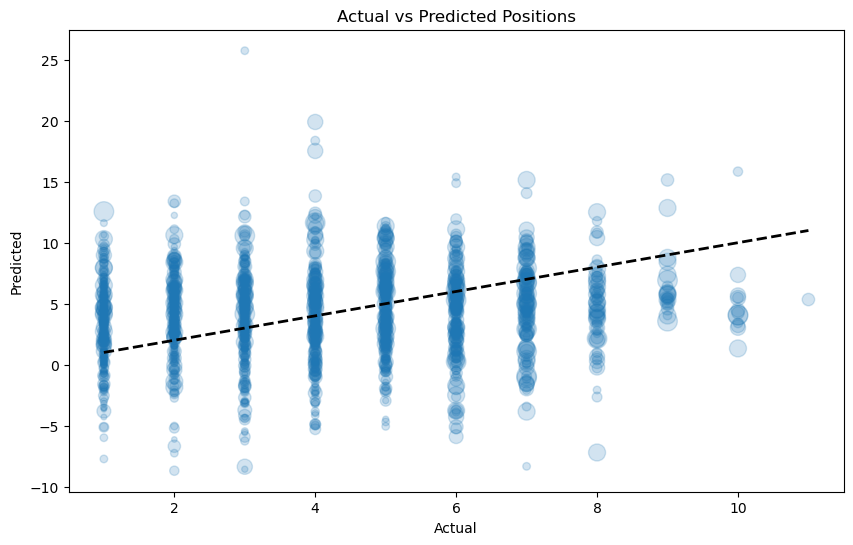

In [59]:
import matplotlib.pyplot as plt
# Assuming 'odds' column is present in the test set
odds = X_test['odds']

# Step 8: Visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.2, s=odds * 10)  # Adjust the multiplier as needed for better visualization
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Positions')
plt.show()

In [60]:
# combine y_test and y_pred into a single DataFrame
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Odds': odds})